# Train a policy using RL

In this notebook, we train a policy using RL to navigate among other agents controlled by navground. We start by defining the same setup as in the introductory "Gym" notebook. As SB3 `SAC` requires flat observartion spaces, we specify it in `ObservationConfig`.

In [13]:
import gymnasium as gym
import numpy as np
from navground import sim
from navground_learning import ControlActionConfig, ObservationConfig
from navground_learning.reward import SocialReward
from navground_learning.env import NavgroundEnv

import warnings
warnings.filterwarnings('ignore')

sensor = sim.load_state_estimation("""
type: Discs
number: 5
range: 5.0
max_speed: 0.12
max_radius: 0
""")

scenario = sim.load_scenario("""
type: Cross
agent_margin: 0.1
side: 4
target_margin: 0.1
tolerance: 0.5
groups:
  -
    type: thymio
    number: 20
    radius: 0.1
    control_period: 0.1
    speed_tolerance: 0.02
    color: gray
    kinematics:
      type: 2WDiff
      wheel_axis: 0.094
      max_speed: 0.12
    behavior:
      type: HL
      optimal_speed: 0.12
      horizon: 5.0
      tau: 0.25
      eta: 0.5
      safety_margin: 0.05
    state_estimation:
      type: Bounded
      range: 5.0
""")

duration = 60.0
time_step = 0.1

action_config = ControlActionConfig(max_acceleration=1.0, max_angular_acceleration=10.0, 
                                    use_acceleration_action=True)

observation_config = ObservationConfig(include_target_distance=True, include_velocity=True, 
                                       include_angular_speed=True, flat=True)

env = gym.make('navground',
    scenario=scenario,
    sensor=sensor,
    action=action_config,
    observation=observation_config,
    reward=SocialReward(),
    time_step=time_step,
    render_mode="rgb_array",
    max_duration=duration);

log_folder = 'logs/RL'

and function to collect and plot the rewards for both types of agents and make a video from a run

In [14]:
from navground.sim.ui.video import display_video_from_run
from navground_learning.behaviors import PolicyBehavior
from navground_learning.evaluate import make_experiment_with_env
from matplotlib import pyplot as plt
from stable_baselines3.common.evaluation import evaluate_policy

def display_run(policy, seed=0, steps=600, color='red', **kwargs):
    experiment = make_experiment_with_env(env.unwrapped, policy=policy, steps=steps)
    experiment.number_of_runs = 1
    experiment.record_config.pose = True
    experiment.run_index = seed
    experiment.steps = steps
    experiment.run()
    experiment.runs[seed].world.agents[0].color = color
    return display_video_from_run(experiment.runs[seed], **kwargs)

def plot_reward(policy=None, number=1, steps=20000, color='red'):
    experiment = make_experiment_with_env(env.unwrapped, policy=policy, reward=env.unwrapped.reward)
    experiment.number_of_runs = number
    experiment.steps = steps
    experiment.run()
    rewards = np.asarray([run.get_record("reward") for run in experiment.runs.values()])
    plt.hist(rewards[..., 1:].flatten(), density=True, 
                 color='black', alpha=0.5, bins=30, 
                 label=f"Agents with original behavior")
    plt.hist(rewards[..., 0].flatten(), density=True, 
                 color=color, alpha=0.5, bins=30,
                 label=f"Agent with policy");
    plt.title(f'Reward distribution')
    ax = plt.gca()
    ax.set_yticks([])
    ax.yaxis.set_tick_params(labelleft=False)
    plt.xlabel("reward")
    plt.ylabel("probability")
    plt.legend()

def print_reward(model, episodes=30):
    reward_mean, reward_std_dev = evaluate_policy(model,  model.get_env(), episodes)
    total_steps = duration / time_step
    reward_mean /= total_steps
    reward_std_dev /= total_steps
    print(f"Reward: {reward_mean:.3f} ± {reward_std_dev:.3f}")

As a reference, we compute the reward of the HL agents:

In [15]:
from navground_learning.evaluate import evaluate_expert

hl_rewards = evaluate_expert(env.unwrapped, runs=30)
total_steps = duration / time_step
number_of_agents = 20
hl_reward_mean = np.mean(hl_rewards) / total_steps / number_of_agents
hl_reward_std_dev = np.std(hl_rewards) / total_steps / number_of_agents
print(f"Reward HL: {hl_reward_mean:.3f} ± {hl_reward_std_dev:.3f}")

Reward HL: -0.193 ± 0.075


## RL learning

In [4]:
from stable_baselines3 import SAC
from stable_baselines3.common.logger import configure

model = SAC("MlpPolicy", env, verbose=0)
model.set_logger(configure(f'{log_folder}/SAC', ["csv", "tensorboard"]))

Let's have a look a the performance before training:

In [5]:
print_reward(model)

Reward: -0.999 ± 0.004


In [6]:
display_run(model.policy, display_width=400, factor=10)

In [7]:
import time

start = time.time()
model.learn(total_timesteps=100_000, progress_bar=True, tb_log_name="SAC");
print(f'Training took {time.time() - start: .0f} seconds')

Output()

Training took  683 seconds


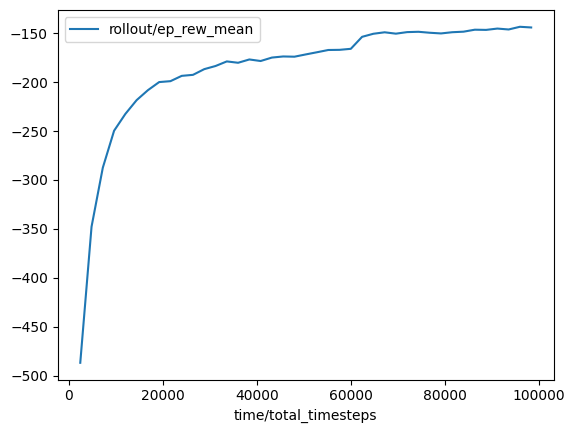

In [8]:
import pandas as pd

df = pd.read_csv(f'{log_folder}/SAC/progress.csv')
df.plot(y='rollout/ep_rew_mean', x='time/total_timesteps');

After training, it performs significantly better and almost on pair with HL. Please note that the performance of the trained agent depends on the other agents' behaviors, something we explore in the `MA-RL` tutorial.

In [9]:
print_reward(model)

Reward: -0.220 ± 0.108


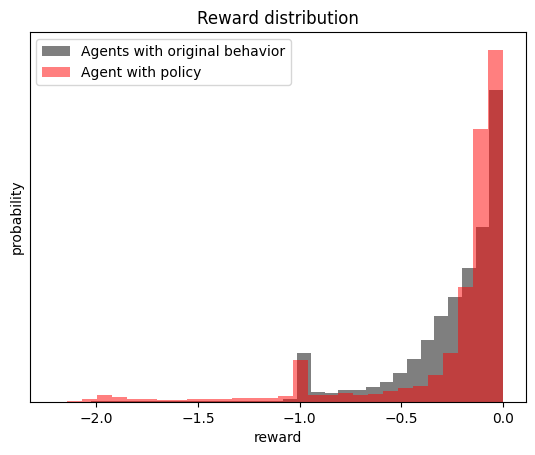

In [10]:
plot_reward(model.policy)

In [11]:
display_run(model.policy, display_width=400, factor=10, steps=2400)

In [12]:
model.save("policies/RL/SAC")